In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aadityasinghal/facial-expression-dataset")

print("Path to dataset files:", path)

100%|██████████| 60.7M/60.7M [00:03<00:00, 17.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aadityasinghal/facial-expression-dataset/versions/1


In [ ]:
TRAIN_DIR = '/root/.cache/kagglehub/datasets/aadityasinghal/facial-expression-dataset/versions/1/train/train/'
TEST_DIR = '/root/.cache/kagglehub/datasets/aadityasinghal/facial-expression-dataset/versions/1/test/test/'

In [ ]:

def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
neutral Completed
happy Completed
sad Completed
surprise Completed
disgust Completed
fear Completed


,image,label
0,/root/.cache/kagglehub/datasets/aadityasinghal...,fear
1,/root/.cache/kagglehub/datasets/aadityasinghal...,fear
2,/root/.cache/kagglehub/datasets/aadityasinghal...,angry
3,/root/.cache/kagglehub/datasets/aadityasinghal...,neutral
4,/root/.cache/kagglehub/datasets/aadityasinghal...,fear


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
neutral Completed
happy Completed
sad Completed
surprise Completed
disgust Completed
fear Completed


,image,label
0,/root/.cache/kagglehub/datasets/aadityasinghal...,angry
1,/root/.cache/kagglehub/datasets/aadityasinghal...,angry
2,/root/.cache/kagglehub/datasets/aadityasinghal...,angry
3,/root/.cache/kagglehub/datasets/aadityasinghal...,angry
4,/root/.cache/kagglehub/datasets/aadityasinghal...,angry


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

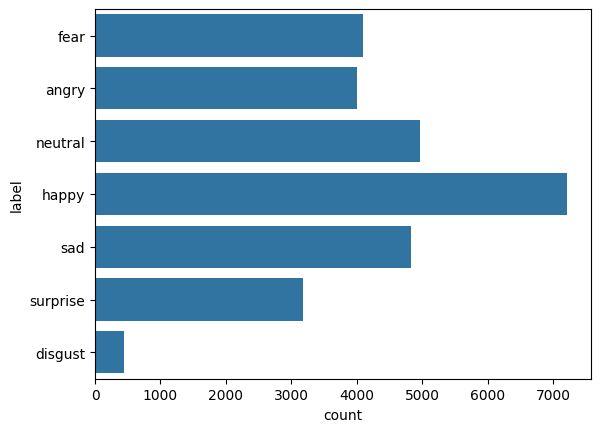

In [ ]:
sns.countplot(train['label'])


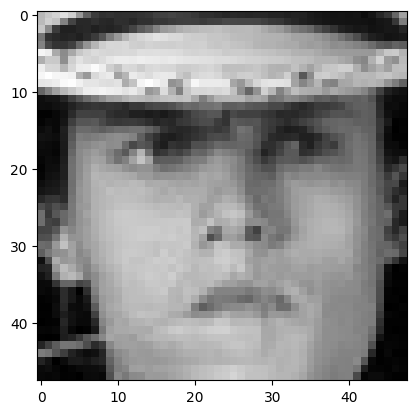

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');


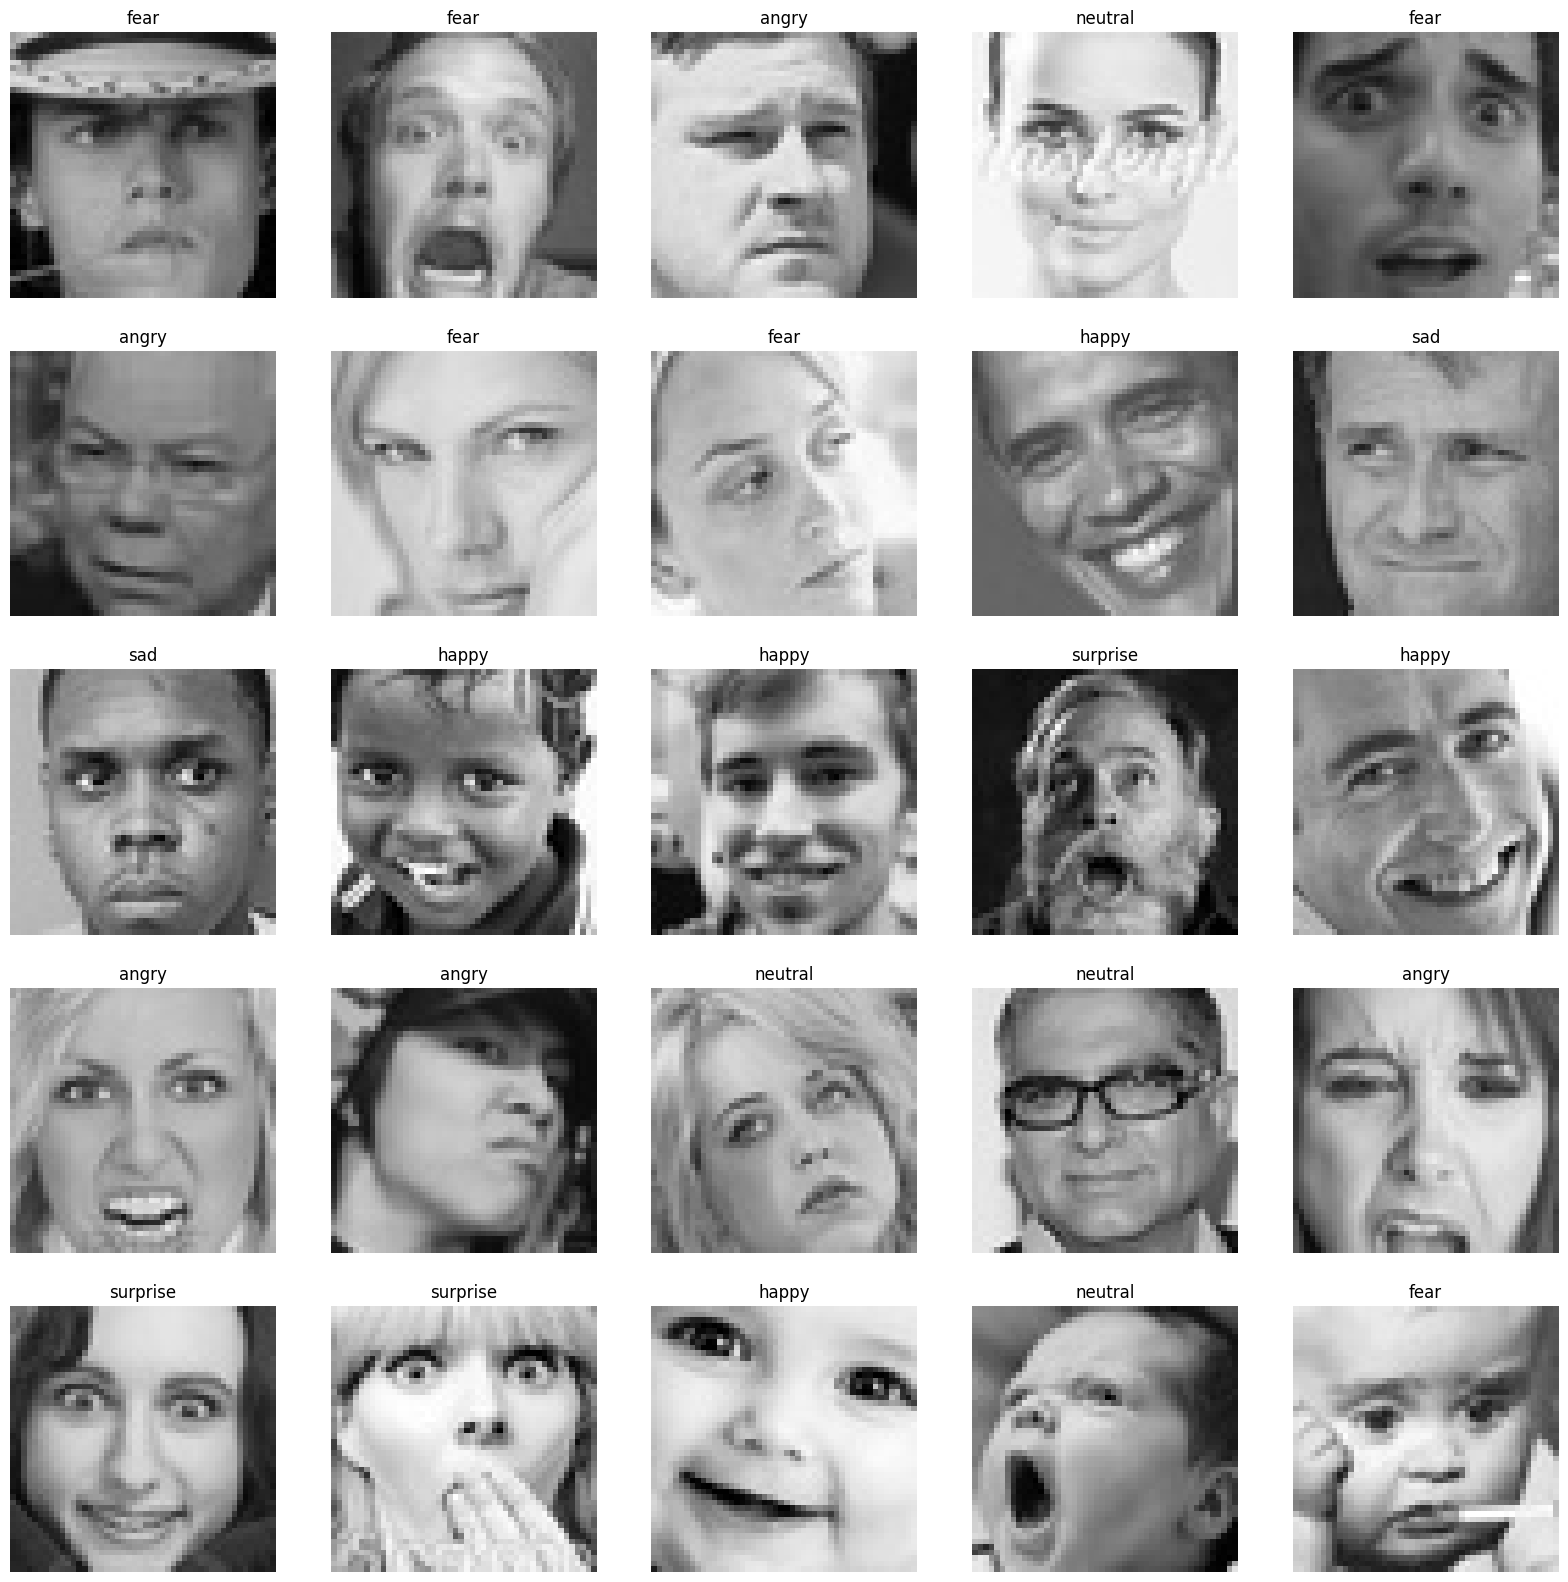

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])


  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
x_train = train_features/255.0

x_test = test_features/255.0


In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [ ]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
img_depth = x_train.shape[3]
num_classes = y_train.shape[1]


## Model Creation

In [ ]:
# @title
# # model = Sequential()
# # # convolutional layers
# # model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# # model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# # model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# # model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.4))

# # model.add(Flatten())
# # # fully connected layers
# # model.add(Dense(512, activation='relu'))
# # model.add(Dropout(0.4))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.3))
# # # output layer
# # model.add(Dense(output_class, activation='softmax'))

# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# def build_net(optim):
#     """
#     This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
#     I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
#     atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
#     results.
#     """
#     net = Sequential(name='DCNN')

#     net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             input_shape=(img_width, img_height, img_depth),
#             activation='relu',
#             padding='same',
#             name='conv2d_1'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_1'))
#     net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             activation='relu',
#             padding='same',
#             name='conv2d_2'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_2'))

#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
#     net.add(Dropout(0.4, name='dropout_1'))

#     net.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='relu',
#             padding='same',
#             name='conv2d_3'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_3'))
#     net.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='relu',
#             padding='same',
#             name='conv2d_4'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_4'))

#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
#     net.add(Dropout(0.4, name='dropout_2'))

#     net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='relu',
#             padding='same',
#             name='conv2d_5'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_5'))
#     net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='relu',
#             padding='same',
#             name='conv2d_6'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_6'))

#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
#     net.add(Dropout(0.5, name='dropout_3'))

#     net.add(Flatten(name='flatten'))

#     net.add(
#         Dense(
#             128,
#             activation='relu',
#             name='dense_1'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_7'))

#     net.add(Dropout(0.6, name='dropout_4'))

#     net.add(
#         Dense(
#             num_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )

#     net.compile(
#         loss='categorical_crossentropy',
#         optimizer=optim,
#         metrics=['accuracy']
#     )

#     net.summary()

#     return net

def build_net(optim):
    # L2 regularizer
    reg = tf.keras.regularizers.l2(1e-4)

    net = Sequential(name='DCNN')

    # First block
    net.add(Conv2D(32, (3,3), input_shape=(img_width, img_height, img_depth),
                   activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.2))

    # Second block
    net.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.3))

    # Third block
    net.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2,2)))
    net.add(Dropout(0.4))

    net.add(Flatten())

    # Dense layers
    net.add(Dense(512, activation='relu', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(Dropout(0.5))

    net.add(Dense(256, activation='relu', kernel_regularizer=reg))
    net.add(BatchNormalization())
    net.add(Dropout(0.5))

    net.add(Dense(num_classes, activation='softmax'))

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.7,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
train_datagen.fit(x_train)

In [ ]:
# train the model
# history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))
epochs = 150
batch_size=128

model = build_net('adam')
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 47s 138ms/step - accuracy: 0.1995 - loss: 2.7451 - val_accuracy: 0.2471 - val_loss: 2.2080 - learning_rate: 0.0010
Epoch 2/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3203 - loss: 2.0178 - val_accuracy: 0.2478 - val_loss: 2.2085 - learning_rate: 0.0010
Epoch 3/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.2821 - loss: 2.0636 - val_accuracy: 0.2970 - val_loss: 1.9169 - learning_rate: 0.0010
Epoch 4/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2891 - loss: 1.9239 - val_accuracy: 0.2937 - val_loss: 1.9198 - learning_rate: 0.0010
Epoch 5/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.3574 - loss: 1.8462 - val_accuracy: 0.4320 - val_loss: 1.6568 - learning_rate: 0.0010
Epoch 6/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3672 - loss: 1.8567 - val_accuracy: 0.4213 - val_loss: 1.6695 - learning_rate: 0.0010
Epoch 7/150
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.4073 -

## Plotting results


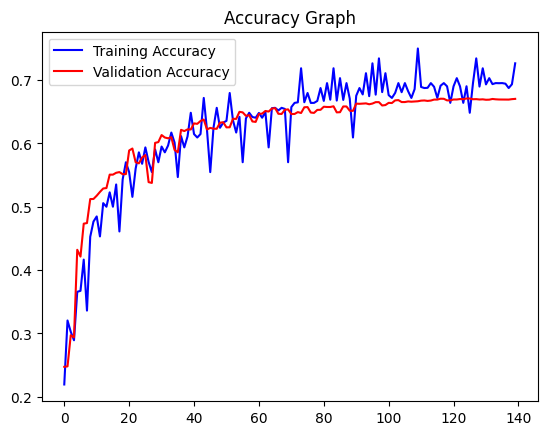

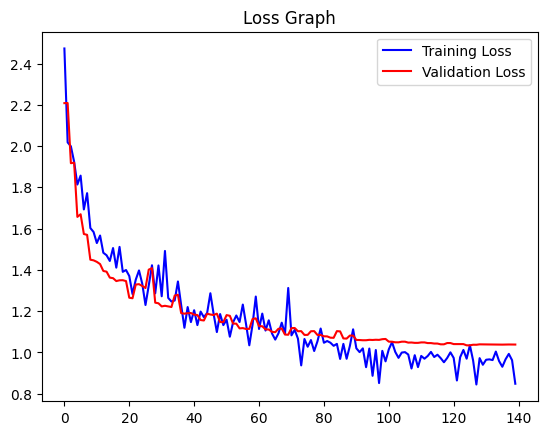

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Testing

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Output: neutral


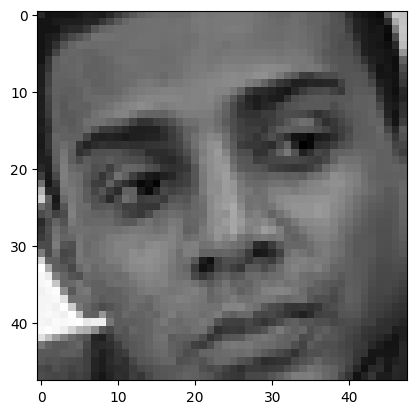

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, figsize=(7, 7)):
    """
    Plots a confusion matrix using seaborn and matplotlib.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        labels: List of label names (optional).
        figsize: Figure size (optional).
    """

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


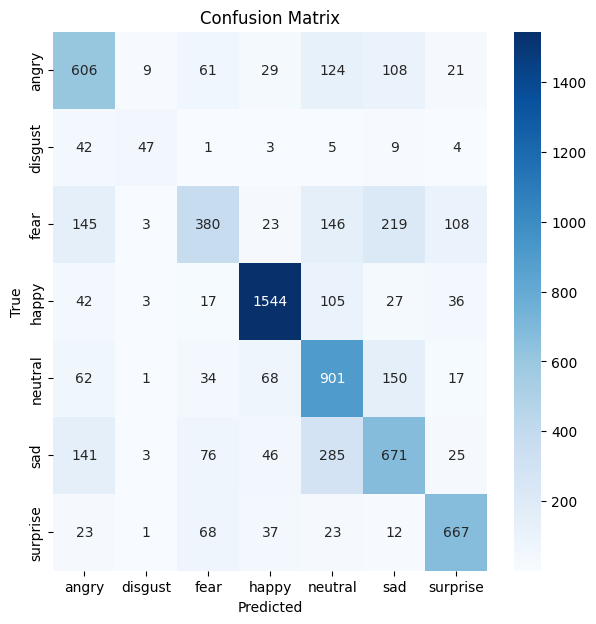

In [ ]:
yhat_valid = np.argmax(model.predict(x_test), axis=-1)
cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_valid)
plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, labels=le.classes_)

In [ ]:


_, accuracy = model.evaluate(x_test, y_test)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7045 - loss: 0.9667
Overall Accuracy: 67.09%


In [ ]:
def get_metrics_per_class(cm, class_labels):
    metrics = {}
    n_classes = len(class_labels)

    for i in range(n_classes):
        # True Positives
        tp = cm[i, i]
        # False Positives
        fp = np.sum(cm[:, i]) - tp
        # False Negatives
        fn = np.sum(cm[i, :]) - tp
        # True Negatives
        tn = np.sum(cm) - (tp + fp + fn)

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        metrics[class_labels[i]] = {
            'Precision': precision * 100,
            'Recall': recall * 100,
            'F1-Score': f1 * 100
        }

    # Calculate overall accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100

    return metrics, accuracy

In [ ]:
# Get and display metrics
metrics, accuracy = get_metrics_per_class(cm, le.classes_)

# Display results in a DataFrame
metrics_df = pd.DataFrame(metrics).T
print("\nMetrics per class:")
print(metrics_df.round(2))
print(f"\nOverall Accuracy: {accuracy:.2f}%")



Metrics per class:
          Precision  Recall  F1-Score
angry         57.12   63.26     60.03
disgust       70.15   42.34     52.81
fear          59.65   37.11     45.76
happy         88.23   87.03     87.63
neutral       56.70   73.07     63.86
sad           56.10   53.81     54.93
surprise      75.97   80.26     78.06

Overall Accuracy: 67.09%
